In [1]:
import torch
import wandb
from hydra import compose, initialize

from dviforbml.evaluation.visualization.visualize_dvinp import visualize_dvinp
from dviforbml.evaluation.visualization.visualize_task import visualize_task
from dviforbml.utils.helper import download_run, get_name_dvinp
from dviforbml.utils.load_dvinp import load_dvinp

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
try:
    import torch_directml

    device = torch_directml.device()
except ImportError:
    device = torch.device("cpu")

In [4]:
# project = "cluster-dvinp-linesine"
# name = "16-None-mean-cos-dis-True-cntxt"  # "16-1-bca-free-dis-True-False-context-1.0-0"
# dir = download_run(project, name)

dir = "../models/dvinp"

In [5]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="cfg")

    model, trainer, test_loader, _ = load_dvinp(
        cfg=cfg,
        device=device,
        dir=dir,
        load_decoder_only=False,
        train_decoder=True,
        debugging=True,
    )

# torch.save(model.decoder.state_dict(), f"{dir}/decoder.pth")


Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 272350.49it/s]
Dropped Escape call with ulEscapeCode : 0x03007703


model not found at ../models/dvinp/model.pth
optim not found at ../models/dvinp/optim.pth


In [ ]:
# torch.save(model.decoder.state_dict(), f"{dir}/decoder.pth")

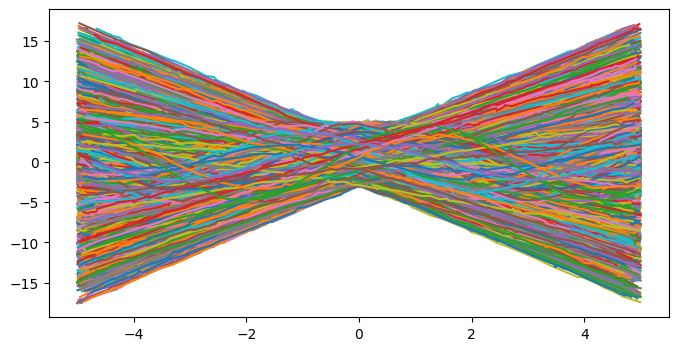

In [6]:
visualize_task(test_loader)

In [7]:
trainer.wandb_logging = True
if trainer.wandb_logging:
    wandb.init(project="troubleshooting-2tasks", name=get_name_dvinp(cfg))

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: max-burzer (max-burzer-karlsruhe-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [17]:
train = True

if train:
    trainer.optimizer.param_groups[0]["lr"] = 0.1 * cfg.training.learning_rate
    # print(trainer.optimizer.param_groups[0]["lr"])

    num_epochs = 1
    losses = trainer.train(
        num_epochs=num_epochs,
        max_clip_norm=cfg.training.max_clip_norm,
        alpha=None,
        validate=False,
    )

    # torch.save(dvinp.state_dict(), f"{dir}/dvinp.pth")

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f987364fdd0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f984cf0e650, raw_cell="train = True

if train:
    trainer.optimizer.para.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://wsl%2Bdebian/home/chickencurry/dviforbml/notebooks/exp_dvinp.ipynb#X10sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

  0%|          | 0/32 [00:00<?, ?it/s, epoch=0, loss=46.3, lmpl=-40.7, mse=32.8]


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f987364fdd0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f984c8b5010, execution_count=17 error_before_exec=None error_in_exec=[Errno 32] Broken pipe info=<ExecutionInfo object at 7f984cf0e650, raw_cell="train = True

if train:
    trainer.optimizer.para.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://wsl%2Bdebian/home/chickencurry/dviforbml/notebooks/exp_dvinp.ipynb#X10sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f987364fdd0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f9869f4b210, raw_cell="max_context_size = 5
num_samples = 900  # num_cell.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://wsl%2Bdebian/home/chickencurry/dviforbml/notebooks/exp_dvinp.ipynb#X11sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

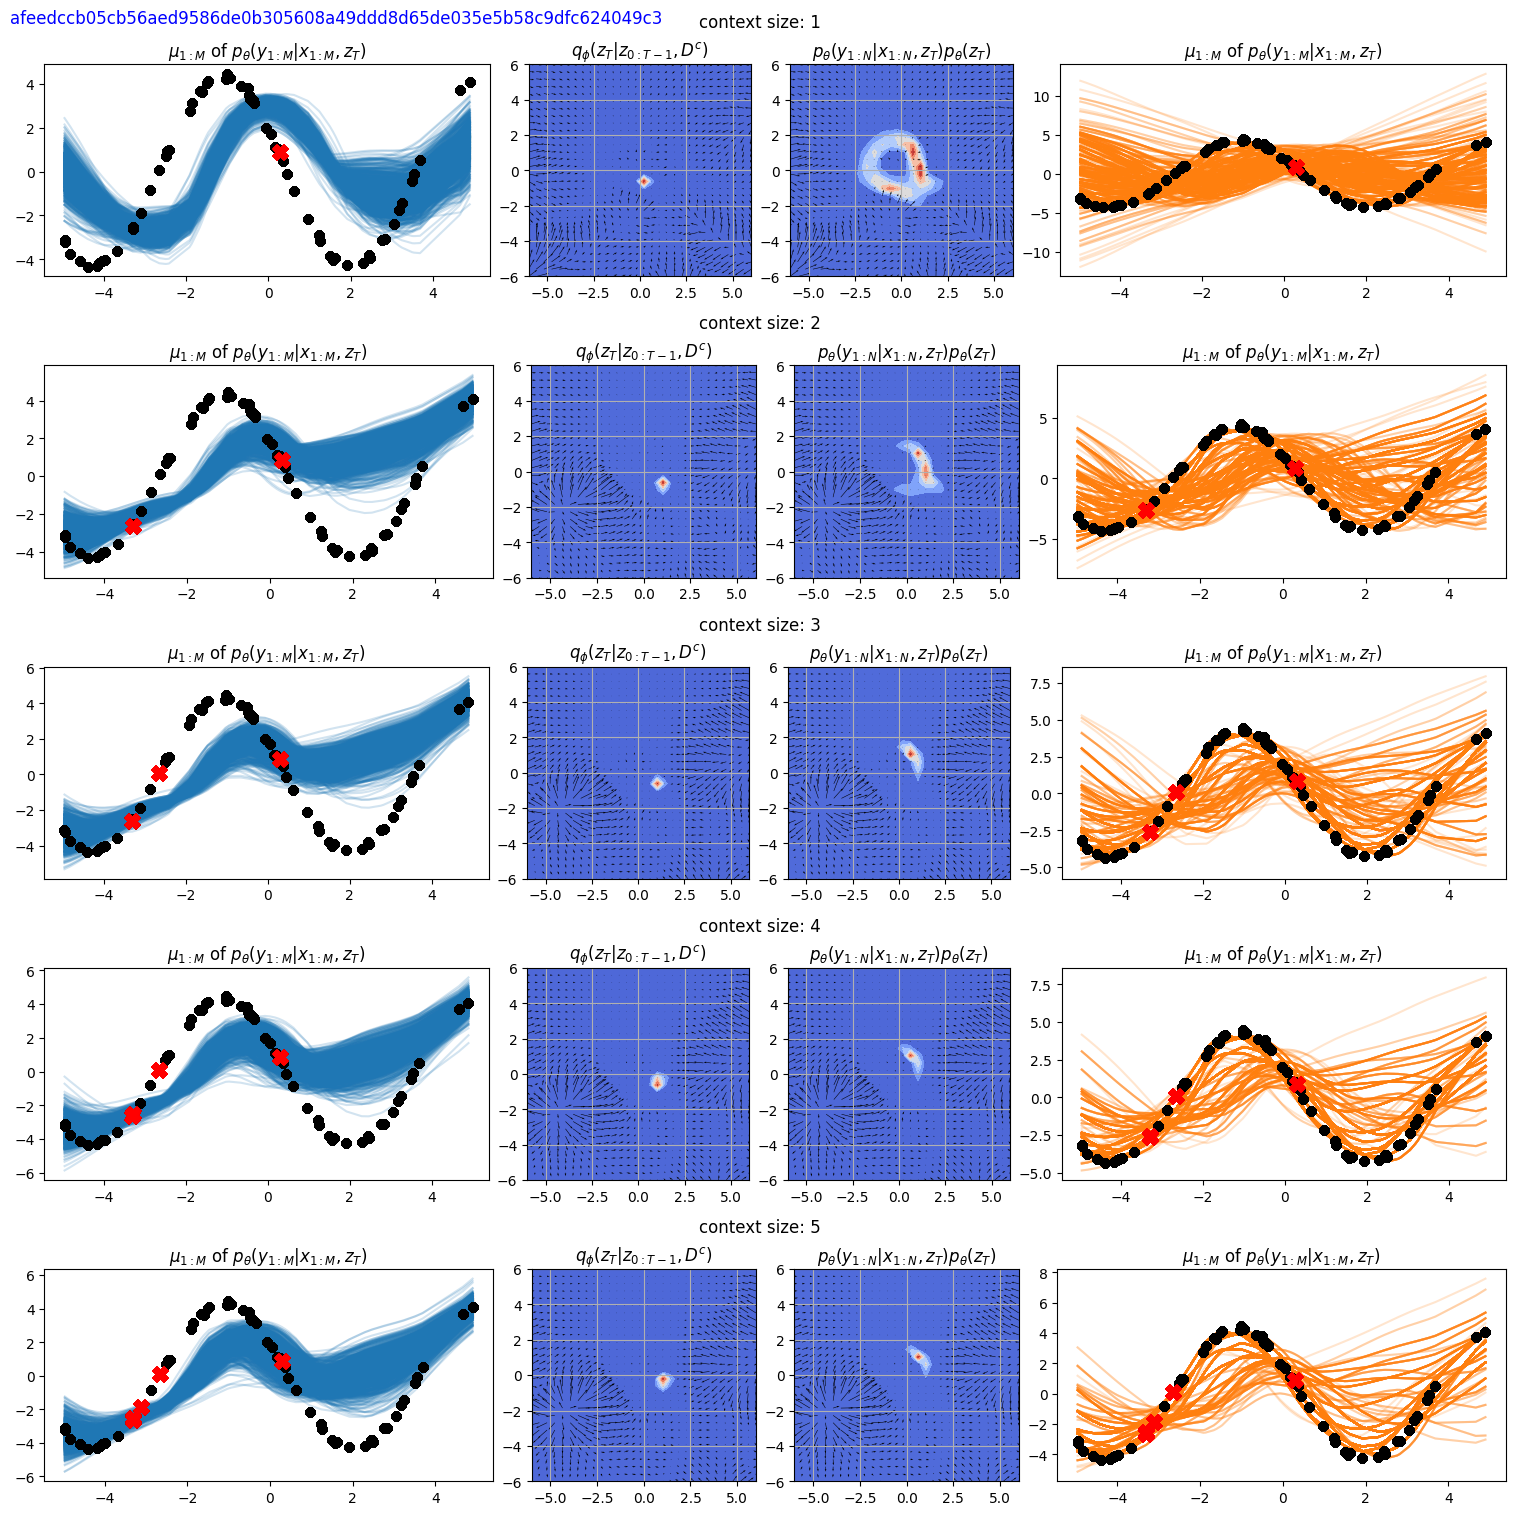

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f987364fdd0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f9824274590, execution_count=13 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f9869f4b210, raw_cell="max_context_size = 5
num_samples = 900  # num_cell.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://wsl%2Bdebian/home/chickencurry/dviforbml/notebooks/exp_dvinp.ipynb#X11sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [13]:
max_context_size = 5
num_samples = 900  # num_cells will be root

ranges = [(-6, 6), (-6, 6)]

targets, samples = visualize_dvinp(
    device=device,
    dvinp=model,
    dataloader=test_loader,
    num_samples=num_samples,
    max_context_size=max_context_size,
    ranges=ranges,
)